In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [56]:
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [132]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [9]:
C = torch.randn((27, 2))

In [14]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [15]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [28]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [29]:
h

tensor([[-0.8017,  0.6214,  0.4407,  ...,  0.0405, -0.9235,  0.7387],
        [-0.7816,  0.3920, -0.7847,  ..., -0.1342, -0.9896,  0.9529],
        [-0.6998,  0.9809,  0.1485,  ..., -0.7974,  0.7926, -0.5062],
        ...,
        [-0.9579, -0.7164, -0.9338,  ...,  0.7868, -0.9919,  0.9930],
        [-0.9740,  0.9990, -0.3341,  ..., -0.6726,  0.9041, -0.6120],
        [ 0.9482,  0.9678,  0.9975,  ..., -0.8521, -0.5489, -0.6218]])

In [30]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [31]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [32]:
counts = logits.exp()

In [33]:
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([32, 27])

In [34]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(18.2150)

In [179]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [180]:
sum(p.nelement() for p in parameters)

11897

In [181]:
for p in parameters:
    p.requires_grad = True

In [182]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [183]:
lri = []
lossi = []
stepi = []

for i in range(200000):
    
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
        
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

2.072082042694092


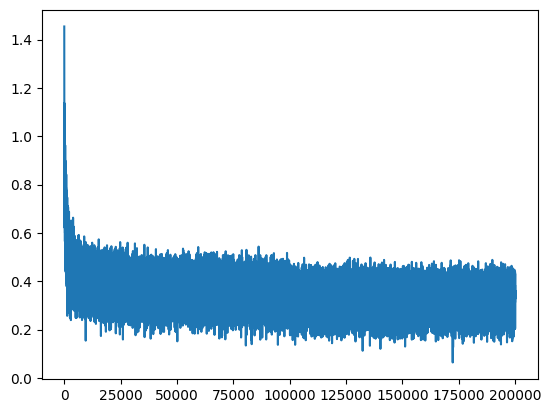

In [184]:
plt.plot(stepi, lossi)

In [185]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1197, grad_fn=<NllLossBackward0>)

In [186]:
emb = C[Xval]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.1623, grad_fn=<NllLossBackward0>)

In [187]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

eriah.
myah.
seel.
nah.
yam.
renyrsleydraeguszeredielin.
shi.
jenne.
elieson.
arleitzimilah.
cayshub.
roshiriel.
kendreth.
konniellanu.
zence.
ryyah.
faehs.
kaysh.
skylanihia.
calynn.
